In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import json
from utils import download_dataset

In [3]:
# Getting test dataset

dataloader, data_path = download_dataset()
corpus, queries_text, qrels = dataloader.load(split="test")

  0%|          | 0/171332 [00:00<?, ?it/s]

In [82]:
def get_length(doc_id: int, mode: str) -> int:
    '''
    Computes the total longitude in characters and the total number of words of combined text and tittle of a document.
    Assigns 512 for total number of word in case the sum of text and title of a document is greater than 512.
    '''
    if mode == 'all':
        return len(corpus[doc_id].get('text')) + len(corpus[doc_id].get('title'))
    if mode == 'words':
        res = len(corpus[doc_id].get('text').split(' ')) + len(corpus[doc_id].get('title').split(' '))
        return res if res < 512 else 512

### BM25

In [138]:
with open('results/results_bm25.json', 'r') as f:
    results = json.load(f)

In [139]:
full_data = pd.DataFrame()
for query in results.keys():
    data = pd.DataFrame({'document':results[query].keys(), 'prob':results[query].values()}).reset_index()
    data['length'] = data['document'].apply(lambda id_: get_length(id_, 'all'))
    data['length_words'] = data['document'].apply(lambda id_: get_length(id_, 'words'))
    full_data = full_data.append(data)

In [140]:
full_data.head()

,index,document,prob,length,length_words
0,0,xfjexm5b,17.678400,1963,270
1,1,28utunid,17.297300,2427,360
2,2,qi1henyy,17.297298,2421,360
3,3,w524alg0,16.891199,1447,219
4,4,480bzpi1,16.846100,2310,321


In [141]:
temp = full_data[['index', 'length', 'length_words']]
temp['index_n'], temp['length_n'], temp['length_words_n'] = preprocessing.normalize([temp['index'], temp['length'], temp['length_words']])

<ipython-input-141-c8e6c1503456>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['index_n'], temp['length_n'], temp['length_words_n'] = preprocessing.normalize([temp['index'], temp['length'], temp['length_words']])


In [142]:
temp[['index', 'length_n', 'length_words_n']].corr()

,index,length_n,length_words_n
index,1.000000,-0.011563,-0.007827
length_n,-0.011563,1.000000,0.920460
length_words_n,-0.007827,0.920460,1.000000


There is no high correlation between amount of words/characters and ranking (index)

In [143]:
results = temp.groupby('index').agg({'length': ['mean', 'std', 'min', 'max'], 'length_words': ['mean', 'std', 'min', 'max']})
results[0:20]

length                        length_words                      
          mean         std  min   max         mean         std  min  max
index                                                                   
0      1590.40  743.045278  354  3673       232.24  109.167828   48  512
1      1535.68  603.343691  564  2866       223.04   85.429279   74  380
2      1594.76  900.200240  481  6512       219.36   89.297659   72  512
3      1662.10  611.816608  558  3228       242.00   87.073743   72  460
4      1609.12  607.449658  631  3228       234.82   88.168135   94  458
5      1557.98  672.875053  446  3268       225.70   92.516353   67  427
6      1609.16  728.952627  493  3967       231.76   99.431765   59  512
7      1464.50  545.939305  540  2929       214.48   80.850641   73  424
8      1592.78  588.248639  609  3307       232.92   85.383132   92  492
9      1637.40  702.825290  493  4051       236.22   97.672357   66  512
10     1459.12  584.107365  493  3410       212.72   85.401582   66  510
11     1425.32  552.312409  430  2989       205.30   77.048951   58  400
12     1667.64  772.981763  663  5702       232.56   80.497727   88  512
13     1708.26  952.378929  622  6758       240.56   98.904027   91  512
14     1691.36  569.645961  520  3112       246.62   83.247330   74  472
15     1721.88  764.164280  520  5716       244.24   82.735763   74  512
16     1516.88  529.237559  387  2565       222.20   77.193370   63  372
17     1594.96  540.904645  736  3725       230.48   77.147947  104  512
18     1527.36  541.582329  266  2792       220.82   77.164465   43  404
19     1501.58  520.274068  404  2999       220.40   76.391580   65  431

In [ ]:
results[0:20].to_csv('bm25.csv')

Text(0, 0.5, 'Number of characters')

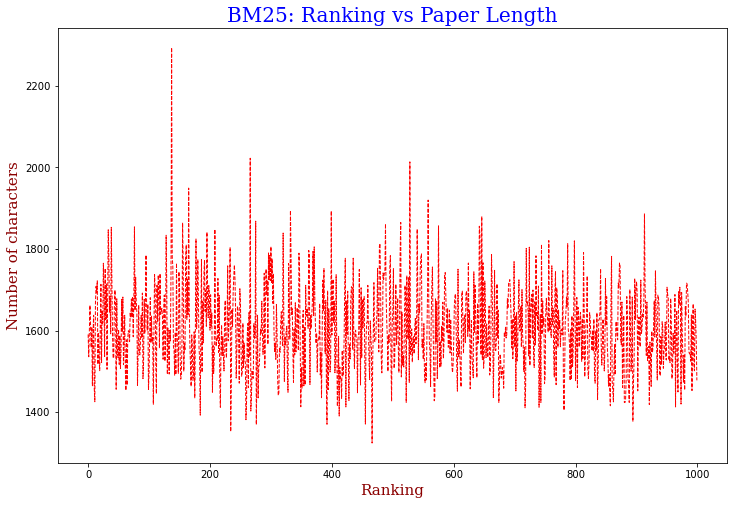

In [104]:
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':15}
plt.figure(num = 3, figsize=(12, 8))  
plt.plot(results.index, results['length']['mean'],color='red',  
         linewidth=1.0,  
         linestyle='--')
plt.title('BM25: Ranking vs Paper Length', fontdict = font1)
plt.xlabel('Ranking', fontdict = font2)
plt.ylabel('Number of characters', fontdict = font2)


Text(0, 0.5, 'Number of words')

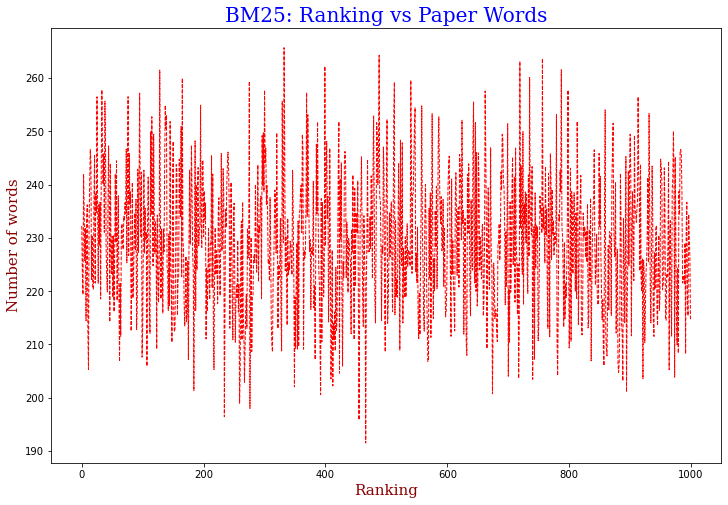

In [103]:
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':15}
plt.figure(num = 3, figsize=(12, 8))  
plt.plot(results.index, results['length_words']['mean'],color='red',  
         linewidth=1.0,  
         linestyle='--')
plt.title('BM25: Ranking vs Paper Words', fontdict = font1)
plt.xlabel('Ranking', fontdict = font2)
plt.ylabel('Number of words', fontdict = font2)


### Cross Encoders

In [158]:
with open('results/results_ce.json', 'r') as f:
    results = json.load(f)

In [159]:
full_data = pd.DataFrame()
for query in results.keys():
    results[query] = {k: v for k, v in sorted(results[query].items(), key=lambda item: item[1], reverse=True)}
    data = pd.DataFrame({'document':results[query].keys(), 'prob':results[query].values()}).reset_index()
    data['length'] = data['document'].apply(lambda id_: get_length(id_, 'all'))
    data['length_words'] = data['document'].apply(lambda id_: get_length(id_, 'words'))
    full_data = full_data.append(data)

In [160]:
full_data

,index,document,prob,length,length_words
0,0,jwxt4ygt,0.993548,706,103
1,1,4dtk1kyh,0.993538,1379,202
2,2,utsr0zv7,0.993530,1010,145
3,3,h3ovjqcn,0.993497,328,47
4,4,1mjaycee,0.993495,1267,171
...,...,...,...,...,...
15,15,pfjq2m42,0.958583,1033,142
16,16,w9zyshzb,0.958308,1035,142
17,17,6emy92i5,0.945937,50,8
18,18,a5sg617l,0.877331,1243,176


In [161]:
temp = full_data[['index', 'length', 'length_words']]
temp['index_n'], temp['length_n'], temp['length_words_n'] = preprocessing.normalize([temp['index'], temp['length'], temp['length_words']])

<ipython-input-161-c8e6c1503456>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['index_n'], temp['length_n'], temp['length_words_n'] = preprocessing.normalize([temp['index'], temp['length'], temp['length_words']])


In [162]:
temp[['index', 'length_n', 'length_words_n']].corr()

,index,length_n,length_words_n
index,1.000000,-0.324650,-0.322028
length_n,-0.324650,1.000000,0.996828
length_words_n,-0.322028,0.996828,1.000000


Apparently there is some negative correlation, which indicates to possible bias

In [163]:
results = temp.groupby('index').agg({'length': ['mean', 'std', 'min', 'max'], 'length_words': ['mean', 'std', 'min', 'max']})
results[0:20]

length                       length_words                     
          mean         std min   max         mean         std min  max
index                                                                 
0      1144.40  574.330666  70  2729       165.70   83.254282  11  395
1      1130.46  590.074025  70  2450       163.26   87.310801  11  357
2      1266.44  616.994002  69  3673       183.68   86.964088  12  509
3      1214.76  650.731568  77  3414       176.76   96.235375  13  510
4      1187.72  754.241477  62  3410       173.92  114.044717   9  510
5      1094.38  728.425192  55  2946       159.66  107.074380   9  435
6      1110.24  760.093001  36  2946       163.48  112.244856   7  435
7      1020.84  789.148220  22  2915       149.46  117.249988   5  462
8       916.74  828.330847  45  3038       134.16  123.655605   7  447
9      1012.04  843.489810  49  3032       145.22  122.791891   7  447
10      934.50  871.893839  44  3445       135.50  126.005061   7  512
11      855.18  857.385482  21  3445       123.46  124.233850   4  512
12      737.74  749.365876  33  2565       106.90  108.179603   6  362
13      855.38  916.558467  23  3682       123.68  131.010740   4  512
14      691.56  828.876253  21  3685        99.50  117.927901   4  512
15      563.54  693.267101  11  2244        80.74   98.902923   2  333
16      567.32  728.186493  17  2653        84.38  107.194252   3  376
17      528.28  752.419961  10  2655        78.04  109.667952   2  376
18      453.02  695.493438  18  2766        65.96   99.996931   4  401
19      405.14  634.827954  25  2706        60.74   95.757732   5  393

In [164]:
results[0:20].to_csv('crossencoder.csv')

Text(0, 0.5, 'Number of characters')

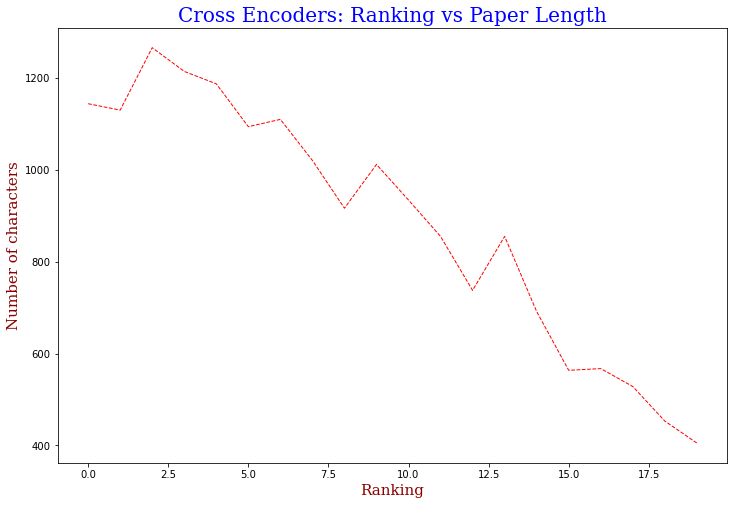

In [165]:
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':15}
plt.figure(num = 3, figsize=(12, 8))  
plt.plot(results.index, results['length']['mean'],color='red',  
         linewidth=1.0,  
         linestyle='--')
plt.title('Cross Encoders: Ranking vs Paper Length', fontdict = font1)
plt.xlabel('Ranking', fontdict = font2)
plt.ylabel('Number of characters', fontdict = font2)


Text(0, 0.5, 'Number of words')

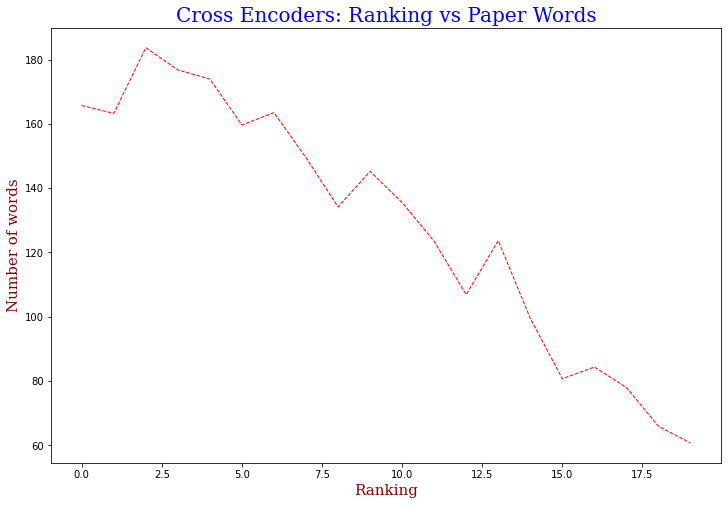

In [166]:
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':15}
plt.figure(num = 3, figsize=(12, 8))  
plt.plot(results.index, results['length_words']['mean'],color='red',  
         linewidth=1.0,  
         linestyle='--')
plt.title('Cross Encoders: Ranking vs Paper Words', fontdict = font1)
plt.xlabel('Ranking', fontdict = font2)
plt.ylabel('Number of words', fontdict = font2)


### Base Model, without Cross Encoders

In [167]:
with open('results/results_without.json', 'r') as f:
    results = json.load(f)

In [168]:
full_data = pd.DataFrame()
for query in results.keys():
    results[query] = {k: v for k, v in sorted(results[query].items(), key=lambda item: item[1], reverse=True)}
    data = pd.DataFrame({'document':results[query].keys(), 'prob':results[query].values()}).reset_index()
    data['length'] = data['document'].apply(lambda id_: get_length(id_, 'all'))
    data['length_words'] = data['document'].apply(lambda id_: get_length(id_, 'words'))
    full_data = full_data.append(data)

In [169]:
full_data

,index,document,prob,length,length_words
0,0,u7u75sl0,0.800144,47,9
1,1,4dtk1kyh,0.584934,1379,202
2,2,nfnzkiyg,0.559354,171,26
3,3,h3ovjqcn,0.552764,328,47
4,4,q8dq3alv,0.550024,170,26
...,...,...,...,...,...
3999,3999,peophh5s,0.161163,57,7
4000,4000,5yl7gvz0,0.161117,39,8
4001,4001,bf8o4t40,0.161104,50,8
4002,4002,jwr9a1fy,0.161049,37,7


In [170]:
temp = full_data[['index', 'length', 'length_words']]
temp['index_n'], temp['length_n'], temp['length_words_n'] = preprocessing.normalize([temp['index'], temp['length'], temp['length_words']])

<ipython-input-170-c8e6c1503456>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['index_n'], temp['length_n'], temp['length_words_n'] = preprocessing.normalize([temp['index'], temp['length'], temp['length_words']])


In [171]:
temp = temp[temp['index']<=1000]
temp[['index', 'length_n', 'length_words_n']].corr()

,index,length_n,length_words_n
index,1.000000,-0.000866,0.000800
length_n,-0.000866,1.000000,0.971331
length_words_n,0.000800,0.971331,1.000000


There is no correlation between ranking and number of words and characters

In [172]:
results = temp.groupby('index').agg({'length': ['mean', 'std', 'min', 'max'], 'length_words': ['mean', 'std', 'min', 'max']})
results[0:20]

length                       length_words                     
          mean         std min   max         mean         std min  max
index                                                                 
0       683.54  788.072544  21  2879        99.00  114.833686   4  419
1       721.62  829.759712  10  3032       104.00  119.342929   2  442
2       756.62  762.801092  33  2880       109.38  109.362884   6  416
3       896.76  816.736301  44  3038       130.00  117.615250   8  442
4      1058.50  858.324382  42  3414       154.08  126.102621   8  510
5       927.08  757.394428  21  3410       136.98  112.885076   4  510
6       835.02  708.027743  30  2578       122.26  103.430310   5  362
7       926.88  713.218621  23  2577       133.74  101.743938   4  362
8       788.38  707.882121  18  2605       115.58  103.138324   4  356
9       930.88  730.989981  25  2397       135.14  107.113903   4  378
10     1057.46  971.162531  11  3682       155.60  145.369620   2  512
11      962.92  858.137895  35  3685       141.10  124.033118   6  512
12      801.32  748.228614  46  2655       116.40  109.116302   7  378
13      828.42  848.644997  16  3673       117.56  118.386113   3  509
14      840.68  724.575807  38  2300       121.40  105.543878   7  359
15      831.10  767.863010  25  2436       121.30  111.596805   5  384
16      906.32  750.674919  17  2787       132.04  111.647762   3  447
17      769.16  665.739220  44  2036       112.28   98.211775   8  333
18      913.60  834.067021  31  3445       134.64  123.741297   5  512
19     1253.42  800.735124  37  3445       181.72  116.186521   6  512

In [173]:
results[0:20].to_csv('basemodel.csv')

Text(0, 0.5, 'Number of characters')

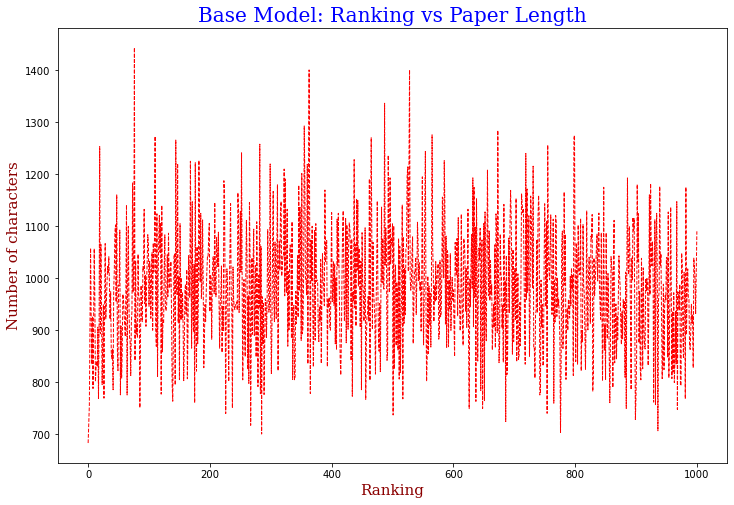

In [174]:
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':15}
plt.figure(num = 3, figsize=(12, 8))  
plt.plot(results.index, results['length']['mean'],color='red',  
         linewidth=1.0,  
         linestyle='--')
plt.title('Base Model: Ranking vs Paper Length', fontdict = font1)
plt.xlabel('Ranking', fontdict = font2)
plt.ylabel('Number of characters', fontdict = font2)


Text(0, 0.5, 'Number of words')

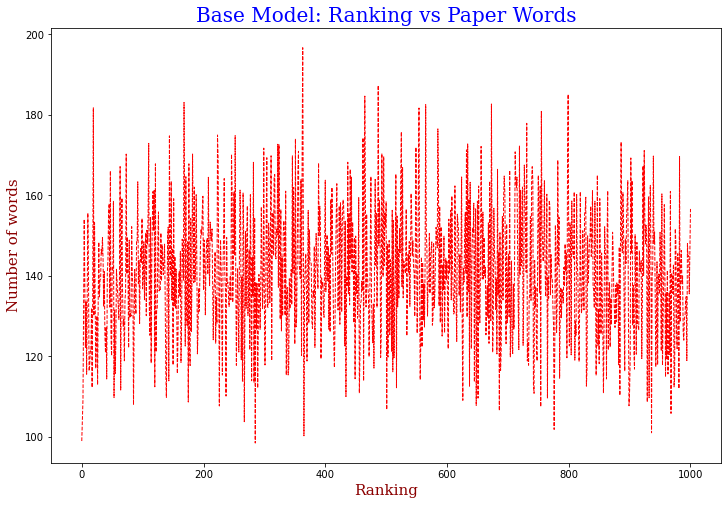

In [175]:
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':15}
plt.figure(num = 3, figsize=(12, 8))  
plt.plot(results.index, results['length_words']['mean'],color='red',  
         linewidth=1.0,  
         linestyle='--')
plt.title('Base Model: Ranking vs Paper Words', fontdict = font1)
plt.xlabel('Ranking', fontdict = font2)
plt.ylabel('Number of words', fontdict = font2)
